In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# toLookChars = "abc"
toLookChars = "abcdefghxRDTFKNBQ123456780+-=#"

data = []
labels = []
maxSize = 0
for i, l in enumerate(os.listdir("curated")):
	if chr(int(l)) in toLookChars:
		maxSize = max(maxSize, len(os.listdir(os.path.join("curated", l))))
		tmpD = []
		for f in os.listdir(os.path.join("curated", l)):
			img = Image.open(os.path.join("curated", l, f))
			img = img.resize((64, 64))
			img = np.array(img)
			img = img.reshape(-1)
			tmpD.append(img)
		labels.append(chr(int(l)))
		data.append(tmpD)

In [3]:
for i in range(len(data)):
	print(labels[i], len(data[i]))

d 1074
e 2962
f 608
g 760
h 990
x 463
# 152
+ 146
- 447
0 1103
1 1036
2 1056
3 1047
4 1028
5 957
6 943
7 1031
8 1055
= 254
B 505
D 553
F 486
K 508
N 689
Q 413
R 816
T 738
a 2219
b 624
c 880


In [4]:
# If there is less than the max size for any character, we add more by translating the image
dataPrim = [d[:] for d in data]
for i in range(len(data)):
	for j in range(maxSize - len(data[i])):
		img = Image.fromarray(data[i][j % len(data[i])].reshape(64, 64), 'L')
		img = img.transform((64, 64), Image.AFFINE, (1, 0, np.random.randint(-2, 2), 0, 1, np.random.randint(-2, 2)))
		img = np.array(img)
		img = img.reshape(-1)
		dataPrim[i].append(img)

In [5]:
for i in range(len(dataPrim)):
	print(labels[i], len(dataPrim[i]))

d 2962
e 2962
f 2962
g 2962
h 2962
x 2962
# 2962
+ 2962
- 2962
0 2962
1 2962
2 2962
3 2962
4 2962
5 2962
6 2962
7 2962
8 2962
= 2962
B 2962
D 2962
F 2962
K 2962
N 2962
Q 2962
R 2962
T 2962
a 2962
b 2962
c 2962


In [6]:
# Prepare the dataset for the training
X = []
y = []
for i in range(len(dataPrim)):
	for j in range(len(dataPrim[i])):
		X.append(dataPrim[i][j])
		y.append(labels[i])

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# Create the model using sklearn and scikit-learn
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10, random_state=22222, tol=0.00000001)

In [8]:
# Train the model
clf.fit(X_train, y_train)

Iteration 1, loss = 2.77648729
Iteration 2, loss = 1.35860637
Iteration 3, loss = 1.06061845
Iteration 4, loss = 0.91908129
Iteration 5, loss = 0.82388031
Iteration 6, loss = 0.75299174
Iteration 7, loss = 0.69242550
Iteration 8, loss = 0.63949434
Iteration 9, loss = 0.59615387
Iteration 10, loss = 0.55867869
Iteration 11, loss = 0.52416204
Iteration 12, loss = 0.49252895
Iteration 13, loss = 0.46348152
Iteration 14, loss = 0.43806609
Iteration 15, loss = 0.41387566
Iteration 16, loss = 0.39555076
Iteration 17, loss = 0.37707525
Iteration 18, loss = 0.35965156
Iteration 19, loss = 0.34120977
Iteration 20, loss = 0.32717444
Iteration 21, loss = 0.31337271
Iteration 22, loss = 0.30069246
Iteration 23, loss = 0.28915774
Iteration 24, loss = 0.27553971
Iteration 25, loss = 0.26481422
Iteration 26, loss = 0.25305272
Iteration 27, loss = 0.24623117
Iteration 28, loss = 0.23993035
Iteration 29, loss = 0.22593649
Iteration 30, loss = 0.22525617
Iteration 31, loss = 0.21493412
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500,
              random_state=22222, solver='sgd', tol=1e-08, verbose=10)

In [9]:
# Test the model
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8519018681071349


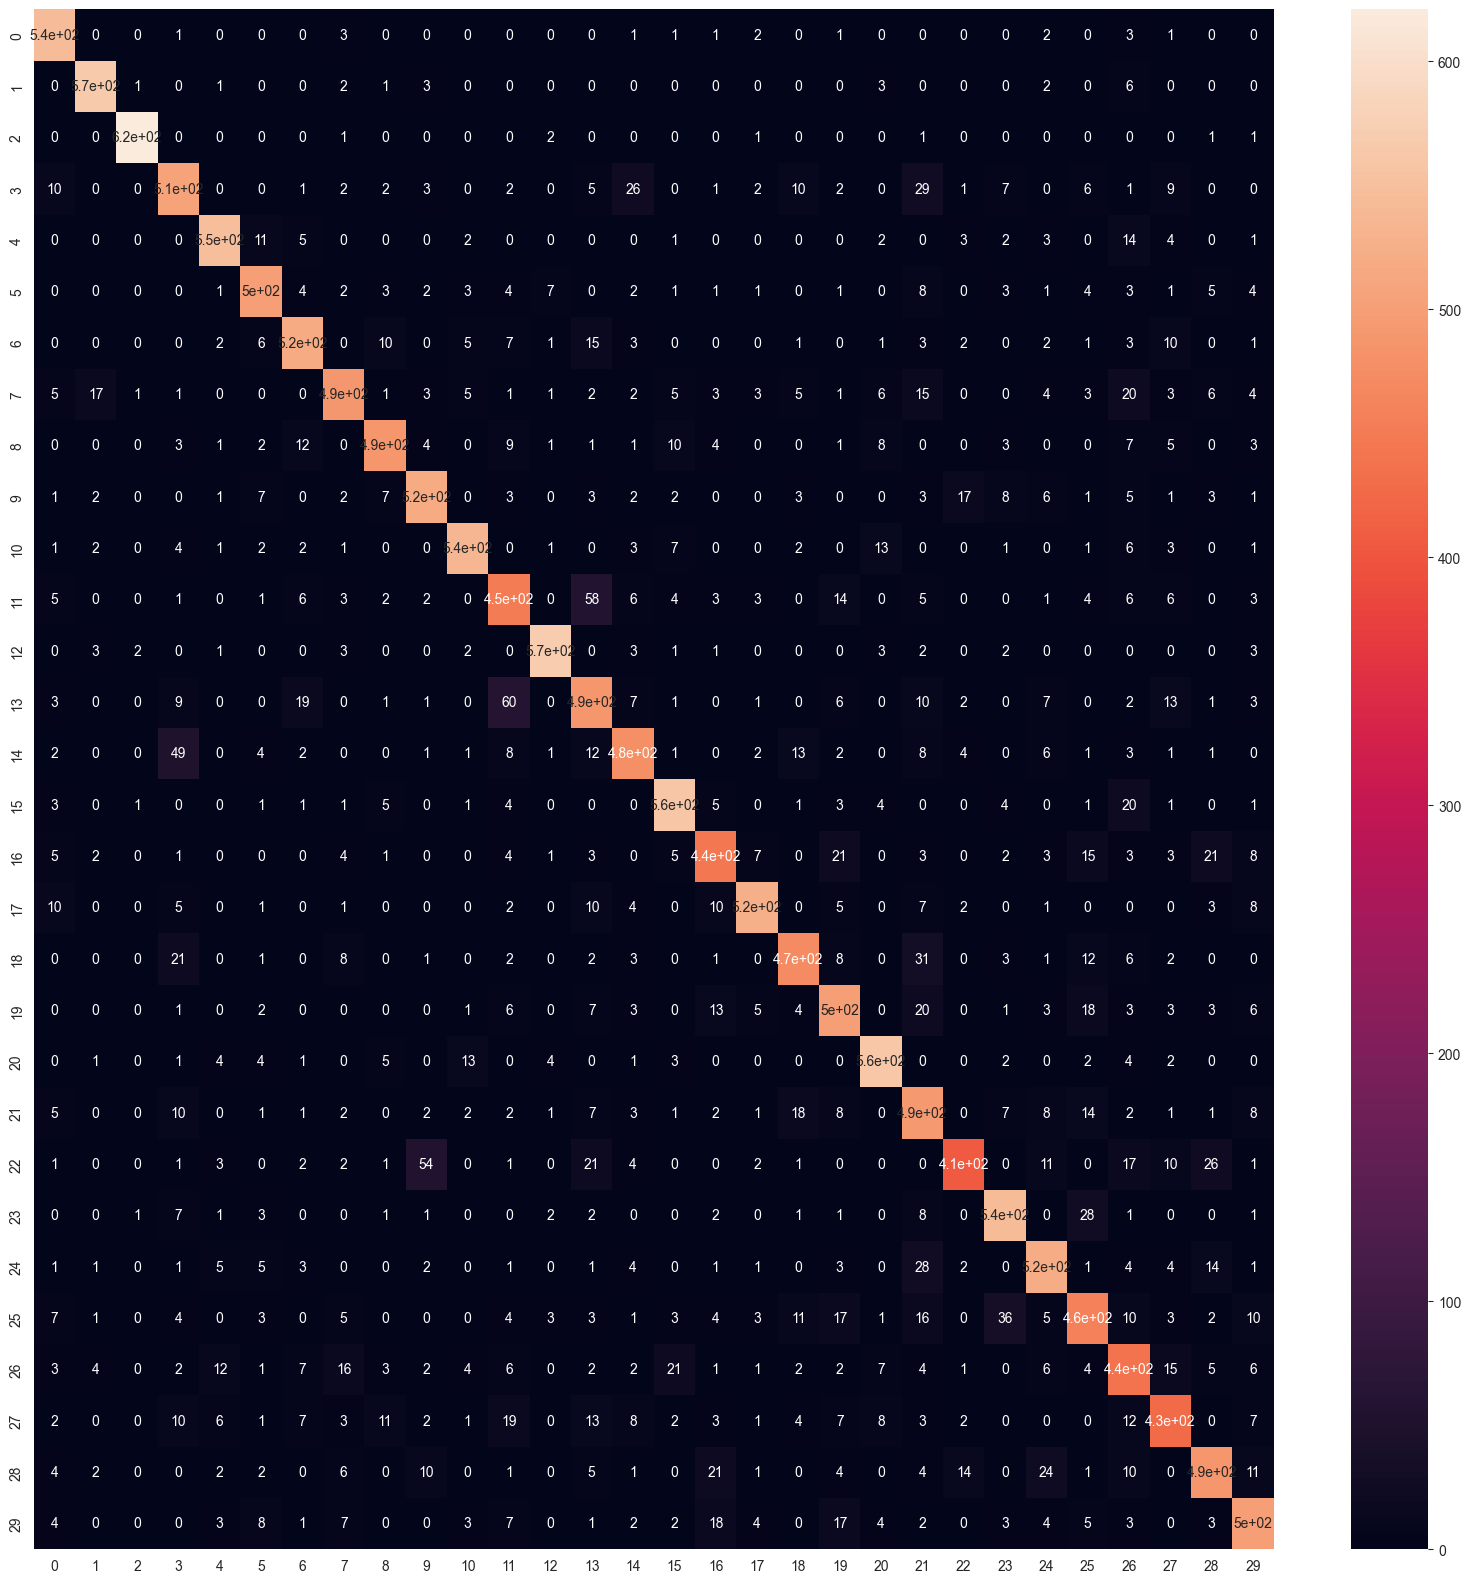

In [10]:
# Show the accuracy matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True)
plt.show()

In [11]:
# Find the 4 most wrong predictions
wrong = {}
wrongIdx = []
for i in range(len(y_test)):
	if y_test[i] != y_pred[i]:
		wrongIdx.append(i)
		if y_test[i] not in wrong:
			wrong[y_test[i]] = 0
		wrong[y_test[i]] += 1
wl = list(wrong)
wl.sort(key=lambda x: wrong[x])
print(wl[-4:])

['f', 'B', 'e', 'b']


Label:  6
Predictions:  ['b', 'h', '6']
Probabilities:  [0.84044879 0.14219428 0.01735436]


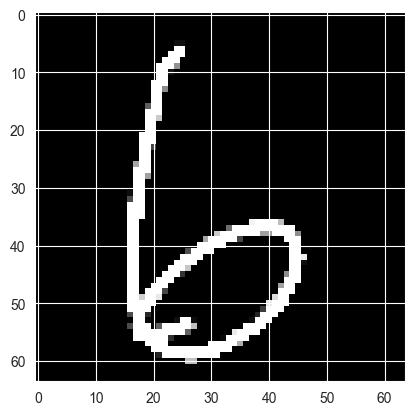

In [12]:
# Print which category corresponds to which index
labels = dict([(i, clf.classes_[i]) for i in range(len(clf.classes_))])

# Check the top 3 predictions for a random failed test image, with the label and the probability
idx = np.random.randint(0, len(wrongIdx))
print("Label: ", y_test[wrongIdx[idx]])
probas = clf.predict_proba(X_test[wrongIdx[idx]].reshape(1, -1))[0]
print("Predictions: ", [labels[v] for v in probas.argsort()[-3:][::-1]])
probas.sort()
print("Probabilities: ", probas[-3:][::-1])
# Show the image
plt.imshow(X_test[wrongIdx[idx]].reshape(64, 64), cmap='gray')
plt.show()

In [13]:
# Save model
pickle.dump(clf, open("characterPredicter/model.sav", 'wb'))